In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

%matplotlib inline

In [ ]:
# rd.seed(42)

In [ ]:
x = rd.sample(range(0, 2500), k=1000)
y = rd.sample(range(0, 3000), k=1000)
data = np.array(list(zip(x,y)))
points = pd.DataFrame({"x":x, "y":y})
# in the future, remove overlapping points

In [ ]:
sns.scatterplot(x = "x", y = "y", data = points, s=10)

In [ ]:
k_means = KMeans(n_clusters=7, random_state=0).fit(data)
labels = k_means.labels_

In [ ]:
points["id"] = labels

In [ ]:
# clustered points
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", s=10)

In [ ]:
points2 = points.copy()
k_means2 = MiniBatchKMeans(n_clusters=7, random_state=0, batch_size=6, max_iter=10).fit(data)
# k_means2 = KMeans(init='random', n_clusters=7, random_state=0).fit(data)
labels2 = k_means2.labels_
points2["id"] = labels2
sns.scatterplot(x = "x", y = "y", hue = "id", data = points2, palette="Set2", s=10)

In [ ]:
diff_points = points2.copy()

In [ ]:
points.value_counts(subset='id').values

In [ ]:
points2.value_counts(subset='id').values

# Using pair-wise distance for k-means clustering points
**Not applicable to general-case dataset, because sklearn.KMeans methods are used, but dataset's clusters are not KMeans.**  
1.To pair the cluster centers per closest one. Cluster centers are generated using centroids.  
2.Change to other cluster criteria to be used with `pair-wise distance`.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

centers1 = k_means.cluster_centers_
centers2 = k_means2.cluster_centers_

In [ ]:
order = pairwise_distances_argmin(centers1, centers2)
centers2 = centers2[order]

In [ ]:
temp_labels = pairwise_distances_argmin(data, centers1)
temp_labels2 = pairwise_distances_argmin(data, centers2)

In [ ]:
different = temp_labels2 == 100

In [ ]:
identical = temp_labels == temp_labels2
different = np.logical_not(identical)

In [ ]:
plt.plot(data[identical, 0], data[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
plt.plot(data[different, 0], data[different, 1], "w", markerfacecolor="m", marker=".")

In [ ]:
points2["new_id"] = temp_labels2
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10)
sns.scatterplot(x = "x", y = "y", hue = "new_id", data = points2, palette="Set2", ax=ax[1], legend=False, s=10)

## Work with the 2 datasets
**Only given `(x,y)` and `id` as inputs.**  
For now, `points` and `points2` shouldn't change anymore.   

**Problem**: when a dataset is clustered, the ID can be different. Since the plotting techniques plot the colors based on the IDs, the coloring for the “same” cluster will also change from dataset-to-dataset, ie. from day-to-day. To determine how to assign the same ID to the “same” cluster helps assign the “same” color to the same cluster, hence making following visualization easier.
If I have access to the clustering technique: assign the ID numbers explicitly. But I don’t have access to the clustering algorithm, hence need to determine the “same” clusters using (x,y) coordinates.

**Method**: use the 1st dataset as a benchmark, use properties of cluster, determine the centroids for all clusters in 1st, and same for all clusters in 2nd. Compare each centroid in 2nd to every centroid in 1st, pick the closest one, then change 2nd那个centroid对应的cluster里所有点的ID to be 1st中最近centroid的cluster的ID.

In [ ]:
print(points.info())
print(points2.info())

In [ ]:
points["coor"] = points.apply(lambda r : [r[0], r[1]], axis=1)
points2["coor"] = points2.apply(lambda r : [r[0], r[1]], axis=1)
print(points.head(3))
print(points2.head(3))

In [ ]:
cp_points = pd.DataFrame(points.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points2 = pd.DataFrame(points2.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))

In [ ]:
print(cp_points.info())
print(cp_points2.info())

#### Using centroids as the criterion.

In [ ]:
def centroid(ls):
    arr = np.array(ls)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [(sum_x/length).round(2), (sum_y/length).round(2)]
cp_points["centroid"] = cp_points.all_coor.apply(lambda r : centroid(r))
cp_points2["centroid"] = cp_points2.all_coor.apply(lambda r : centroid(r))

In [ ]:
print(cp_points.head(3))
print(cp_points2.head(3))

In [ ]:
order = pairwise_distances_argmin(list(cp_points2["centroid"]), list(cp_points["centroid"]))
new_id = cp_points["centroid"][order].index
cp_points2["id"] = new_id

In [ ]:
temp = cp_points2.explode("all_coor")[["id", "all_coor"]]
temp["x"] = temp.all_coor.apply(lambda x : x[0])
temp["y"] = temp.all_coor.apply(lambda x : x[1])
new_points2 = temp
new_points2.head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10)
sns.scatterplot(x = "x", y = "y", hue = "id", data = new_points2, palette="Set2", ax=ax[1], s=10)
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D")
sns.scatterplot(x = list(zip(*cp_points2["centroid"]))[0], 
                y = list(zip(*cp_points2["centroid"]))[1], ax=ax[1], marker="D")

In [ ]:
points2 = new_points2.copy()
points2.rename(columns = {"all_coor":"coor"}, inplace=True)

#### C-shaped cluster, no additional clusters. (still working with 7 groups)

In [ ]:
points3 = points2.copy() # should've been diff_points.copy()

In [ ]:
keep_id_one = lambda x,y : x >= -1/250*(y-500)**2 + 2000

In [ ]:
def change_id(row):
    if row["id"] != 1:
        return row["id"]
    elif keep_id_one(row["x"], row["y"]):
        return 1
    else:
        return 5

In [ ]:
points3["id"] = points3.apply(lambda row : change_id(row), axis=1)

In [ ]:
cp_points3 = pd.DataFrame(points3.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points3["centroid"] = cp_points3.all_coor.apply(lambda r : centroid(r))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10).set(title="Dataset: points")
sns.scatterplot(x = "x", y = "y", hue = "id", data = points3, palette="Set2", ax=ax[1], legend=False, s=10).set(title="Dataset: points3")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D", color="orange")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[1], marker="s", color="green")
sns.scatterplot(x = list(zip(*cp_points3["centroid"]))[0], 
                y = list(zip(*cp_points3["centroid"]))[1], ax=ax[1], marker="D", color="orange")

#### Change the centered cluster into c-shape

#### Additional cluster

In [ ]:
points4 = diff_points.copy()
keep_id_four = lambda x,y : y > x-1300
def change_id(row):
    if row["id"] != 4:
        return row["id"]
    elif keep_id_four(row["x"], row["y"]):
        return 4
    else:
        return 7

In [ ]:
points4["id"] = points4.apply(lambda row : change_id(row), axis=1)
sns.scatterplot(x = "x", y = "y", hue = "id", data = points4, palette="Set2", s=10).set(title="Dataset: points4")

In [ ]:
cp_points4 = pd.DataFrame(points4.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points4["centroid"] = cp_points4.all_coor.apply(lambda r : centroid(r))
order = pairwise_distances_argmin(list(cp_points4["centroid"]), list(cp_points["centroid"]))
order

In [ ]:
cp_points["centroid"][order]
new_id = cp_points["centroid"][order].index
cp_points4["id"] = new_id

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10).set(title="Dataset: points")
sns.scatterplot(x = "x", y = "y", hue = "id", data = points4, palette="Set2", ax=ax[1], legend=False, s=10).set(title="Dataset: points4")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D", color="orange")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[1], marker="s", color="green")
sns.scatterplot(x = list(zip(*cp_points4["centroid"]))[0], 
                y = list(zip(*cp_points4["centroid"]))[1], ax=ax[1], marker="D", color="orange")

# Using CT_Clusters.csv dataset

## A. Work with the original dataset
### A.1 Some EDA and preliminary data visualization

In [2]:
df_clusters = pd.read_csv("./CT_Clusters.csv")
print(df_clusters.info())
print(df_clusters.describe())
df_clusters.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12828 entries, 0 to 12827
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cluster_membership  12828 non-null  int64  
 1   lat_round           12828 non-null  float64
 2   lon_round           12828 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 300.8 KB
None
       cluster_membership     lat_round     lon_round
count        12828.000000  12828.000000  12828.000000
mean             9.625896     41.515125    -72.870864
std              5.705690      0.257943      0.446928
min              1.000000     41.002000    -73.697000
25%              5.000000     41.310000    -73.221000
50%              9.000000     41.515000    -72.892000
75%             14.000000     41.736000    -72.601000
max             20.000000     42.042000    -71.799000


cluster_membership  lat_round  lon_round
0                  10     41.571    -73.018
1                  19     41.814    -72.259
2                  19     41.814    -72.259
3                  19     41.814    -72.259
4                  10     41.594    -73.051

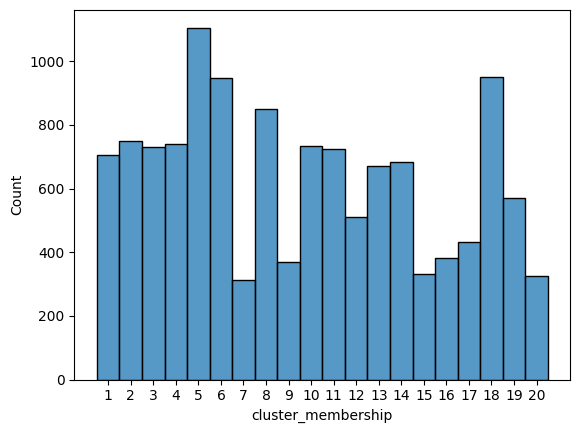

In [3]:
sns.histplot(x = "cluster_membership", data = df_clusters, discrete = True)
plt.xticks(range(min(df_clusters["cluster_membership"]), max(df_clusters["cluster_membership"]) + 1))
plt.show()

In [4]:
'''
The max number of unique(qualitative) coloring schemes in matplotlib/seaborn is 12.
Hence need to create our own.
'''
coloring = sns.color_palette("Spectral", n_colors=20)
# coloring = sns.color_palette("icefire", n_colors=20)
light_coloring = sns.light_palette("purple", n_colors=20)
dark_coloring = sns.dark_palette("purple", n_colors=20)

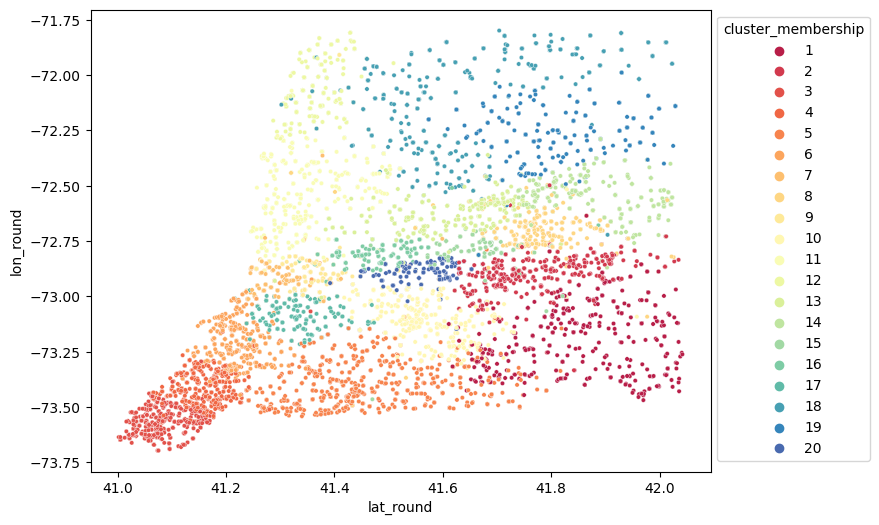

In [5]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x = "lat_round", y = "lon_round", data = df_clusters, hue = "cluster_membership",
                     palette = coloring, s=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### A.2 Plot the centroids. 

In [5]:
def centroid(ls):
    arr = np.array(ls)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [(sum_x/length).round(2), (sum_y/length).round(2)]

In [6]:
def all_coor(df):
    return list(zip(df["lat_round"], df["lon_round"]))

In [7]:
# An easier way to aggregate all points coordinates in a group, using Groupby.apply()
df_centroids = pd.DataFrame(df_clusters.groupby("cluster_membership").apply(all_coor).reset_index(name = "coordinates"))
df_centroids.set_index("cluster_membership", inplace = True)
df_centroids["centroid"] = df_centroids["coordinates"].apply(lambda r : centroid(r))
df_centroids.head()

coordinates  \
cluster_membership                                                      
1                   [(42.009, -73.181), (42.009, -73.181), (42.009...   
2                   [(41.893, -72.765), (41.639, -72.841), (41.855...   
3                   [(41.02, -73.626), (41.054, -73.531), (41.054,...   
4                   [(41.163, -73.373), (41.163, -73.373), (41.163...   
5                   [(41.682, -73.487), (41.682, -73.487), (41.682...   

                           centroid  
cluster_membership                   
1                   [41.85, -73.17]  
2                   [41.77, -72.89]  
3                   [41.08, -73.57]  
4                   [41.15, -73.41]  
5                    [41.45, -73.4]

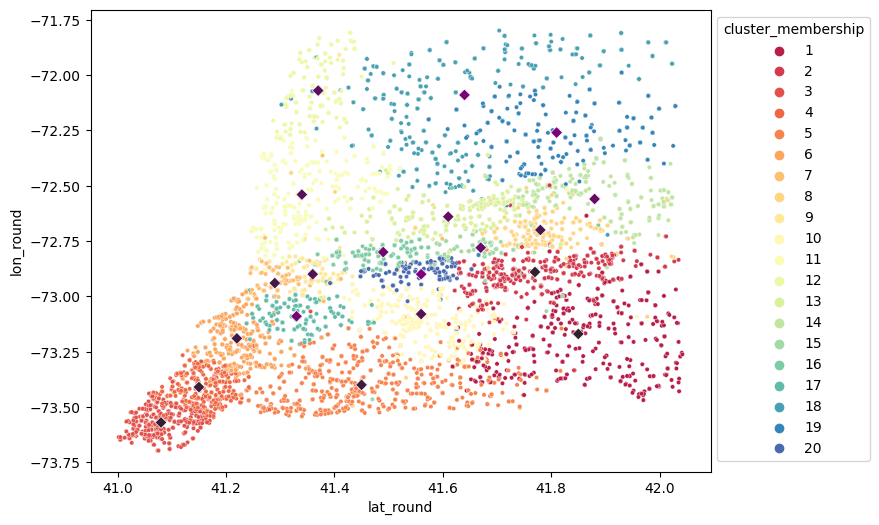

In [9]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x = "lat_round", y = "lon_round", data = df_clusters, hue = "cluster_membership", 
                     palette=coloring, s=10)
sns.scatterplot(x = list(zip(*df_centroids["centroid"]))[0], 
                y = list(zip(*df_centroids["centroid"]))[1], 
                marker="D", legend=False, hue=df_centroids.index, palette=dark_coloring)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## B. Generate multiple membership assignments (using K-means or other ways)
<span style="color:red">**The following is used to generate `new_Clusters.csv`, hence don't run it repeatedly.**</span>

***NOTE: Generate 15 k-means id's, 1 original id's, 1 minibatch-k id's***

 **Data prep, create k-means generator.**

In [8]:
df_new = df_clusters.copy()
coord = np.array(list(zip(df_new["lat_round"], df_new["lon_round"])))
n_clusters = df_new["cluster_membership"].nunique()

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_new["col_1"] = kmeans.fit(coord).labels_+1
kmeansmb = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=6, max_iter=10)
df_new["col_16"] = kmeansmb.fit(coord).labels_+1

Text(0.5, 1.0, 'Day_16')

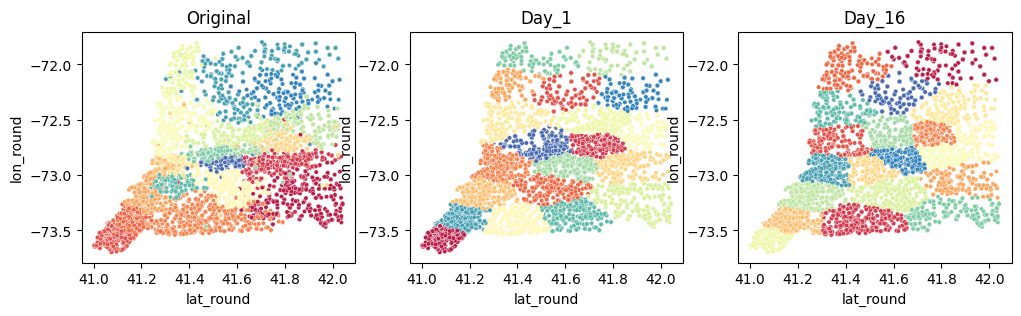

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "cluster_membership", 
                palette = coloring, s=10, legend=False, ax=ax[0])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_1", 
                palette = coloring, s=10, legend=False, ax=ax[1])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_16", 
                palette = coloring, s=10, legend=False, ax=ax[2])
ax[0].set_title("Original")
ax[1].set_title("Day_1")
ax[2].set_title("Day_16")

**Create jittering function. Can choose to jitter x, y, or both. Can also choose the jittering variance in a normal distribution.**

In [10]:
from numpy.random import RandomState

def jitter(coor, sigmax, sigmay, seed=12345):
    """
    Jitter a single point using Gaussian distribution.
    Input:
        coor - List[Float, Float]: coordinate of the point
        sigmax - Float: standard deviation for x, non-negative. If negative, return original x.
        sigmay - Float: standard deviation for y, non-negative. If negative, return original y.
        seed - Int: choose the seed for random generator of normal distribution. Can ensure reproducibility.
    Output:
        [new_x, new_y] - List[Float, Float]: new coordinate for the input point.
    """
    prng = RandomState(seed)
    x, y = coor[0], coor[1]
    new_x, new_y = x, y
    
    if sigmax >= 0:
        new_x = prng.normal(x, scale=sigmax)
    if sigmay >= 0:
        new_y = prng.normal(y, scale=sigmay)
    return [new_x, new_y]

In [11]:
def new_membership(coord):
    """
    Input: coord - np.array[[Float, Float], ...]
    Output: new_coord - np.array[[Float, Float], ...]
    """
    new_coord = list()
    for c in coord:
        temp = jitter(c, sigmax=rd.uniform(-0.5,0.5), sigmay=rd.uniform(-0.1,0.1))
        new_coord.append(temp)
    return np.array(new_coord)

In [12]:
new_coord = new_membership(coord)
df_new["col_2"] = kmeans.fit(new_coord).labels_+1

Text(0.5, 1.0, 'Day_2')

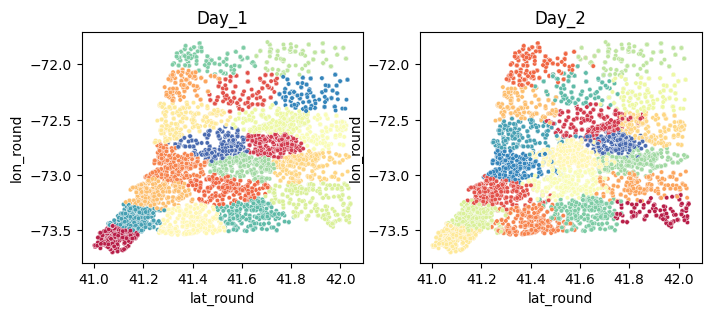

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_1", 
                palette = coloring, s=10, legend=False, ax=ax[0])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_2", 
                palette = coloring, s=10, legend=False, ax=ax[1])
ax[0].set_title("Day_1")
ax[1].set_title("Day_2")

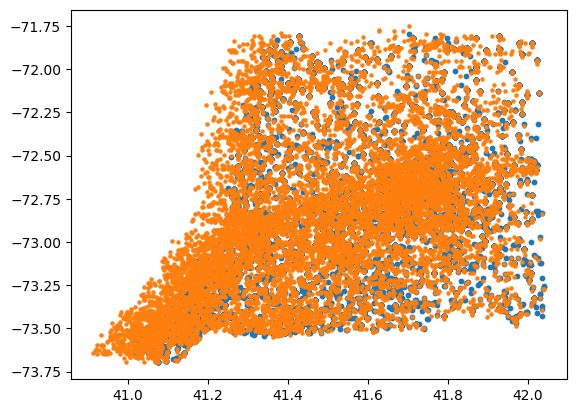

In [14]:
plt.scatter(coord[:,0], coord[:,1], s=10)
plt.scatter(new_coord[:,0], new_coord[:,1], s=5)

**Apply to generate 13 more assignments.**

In [13]:
# cur_coord = new_coord
# for i in range(13):
#     col = "col_" + str(i+3)
#     new = new_membership(cur_coord)
#     df_new[col] = kmeans.fit(new).labels_
#     cur_coord = new
#     print(f'{col} finished generating.')

"""
Always jitter the original coordinates, otherwise it gets too chaotic.
"""
for i in range(13):
    col = "col_" + str(i+3)
    new = new_membership(coord)
    df_new[col] = kmeans.fit(new).labels_+1
    print(f'{col} finished generating.')

col_3 finished generating.
col_4 finished generating.
col_5 finished generating.
col_6 finished generating.
col_7 finished generating.
col_8 finished generating.
col_9 finished generating.
col_10 finished generating.
col_11 finished generating.
col_12 finished generating.
col_13 finished generating.
col_14 finished generating.
col_15 finished generating.


In [14]:
temp = df_new.pop("col_16")
df_new["col_16"] = temp
df_new.head()

cluster_membership  lat_round  lon_round  col_1  col_2  col_3  col_4  \
0                  10     41.571    -73.018     15      9      2      8   
1                  19     41.814    -72.259     19     19      5      5   
2                  19     41.814    -72.259     19     19      5      5   
3                  19     41.814    -72.259     19     19      5      5   
4                  10     41.594    -73.051      4      9      2      8   

   col_5  col_6  col_7  col_8  col_9  col_10  col_11  col_12  col_13  col_14  \
0     20      4     19     12     17      12       1       9       3       5   
1      6     11      3     14      2       5      12      18      11       7   
2      6     11      3     14      2       5      12      18      11       7   
3      6     11      3     14      2       5      12      18      11       7   
4     20      4     19     12     17      12      10       9       3       5   

   col_15  col_16  
0       8       8  
1      14       9  
2      14       9  
3      14       9  
4       8      13

In [15]:
df_new.to_csv('new_Clusters.csv', index=False)

In [20]:
!less new_Clusters.csv

cluster_membership,lat_round,lon_round,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16
10,41.571,-73.018,14,10,18,19,17,19,1,12,8,1,1,16,7,2,16,7
19,41.814,-72.259,18,11,16,4,14,10,14,1,18,14,17,17,6,8,10,8
19,41.814,-72.259,18,11,16,14,14,10,14,1,18,14,17,17,6,8,10,8
19,41.814,-72.259,18,11,16,4,14,10,14,1,18,14,17,17,6,8,10,8
10,41.594,-73.051,3,10,18,19,17,19,1,12,8,1,1,1,7,2,16,12
3,41.02,-73.626,0,8,2,0,0,8,2,6,1,6,11,4,13,18,0,11
7,41.334,-72.945,4,18,19,3,6,4,6,8,11,16,5,8,4,7,17,17
7,41.334,-72.945,4,18,19,3,6,4,6,8,11,16,5,8,4,7,17,17
8,41.893,-72.765,10,14,14,13,10,1,16,17,10,2,19,15,12,6,4,10
8,41.893,-72.765,10,14,14,13,10,1,15,11,10,2,19,2,12,6,4,10
2,41.893,-72.765,10,14,14,13,7,1,15,5,10,18,19,15,11,6,4,10
14,41.788,-72.601,11,7,1,5,13,5,16,11,0,7,0,11,12,1,4,4
14,41.788,-72.601,11,7,17,5,13,5,0,5,13,7,19,19,2,13,19,4
8,41.788,-72.601,11,1,1,5,13,16,16,11,13,7,19,19,2,13,4,4
14,41.788,-72.601,11,7,17,9,13,16,0,5,13,7

## C. Work with the new dataset
1. Calculate the centroids. 
2. Use pairwise-distance to detect "same" id numbers. (check if this works)

### C.1 Plot all 17 clusters, from `new_Clusters.csv`.

In [17]:
df_new = pd.read_csv("./new_Clusters.csv")
df_new.head()

cluster_membership  lat_round  lon_round  col_1  col_2  col_3  col_4  \
0                  10     41.571    -73.018     15      9      2      8   
1                  19     41.814    -72.259     19     19      5      5   
2                  19     41.814    -72.259     19     19      5      5   
3                  19     41.814    -72.259     19     19      5      5   
4                  10     41.594    -73.051      4      9      2      8   

   col_5  col_6  col_7  col_8  col_9  col_10  col_11  col_12  col_13  col_14  \
0     20      4     19     12     17      12       1       9       3       5   
1      6     11      3     14      2       5      12      18      11       7   
2      6     11      3     14      2       5      12      18      11       7   
3      6     11      3     14      2       5      12      18      11       7   
4     20      4     19     12     17      12      10       9       3       5   

   col_15  col_16  
0       8       8  
1      14       9  
2      14       9  
3      14       9  
4       8      13

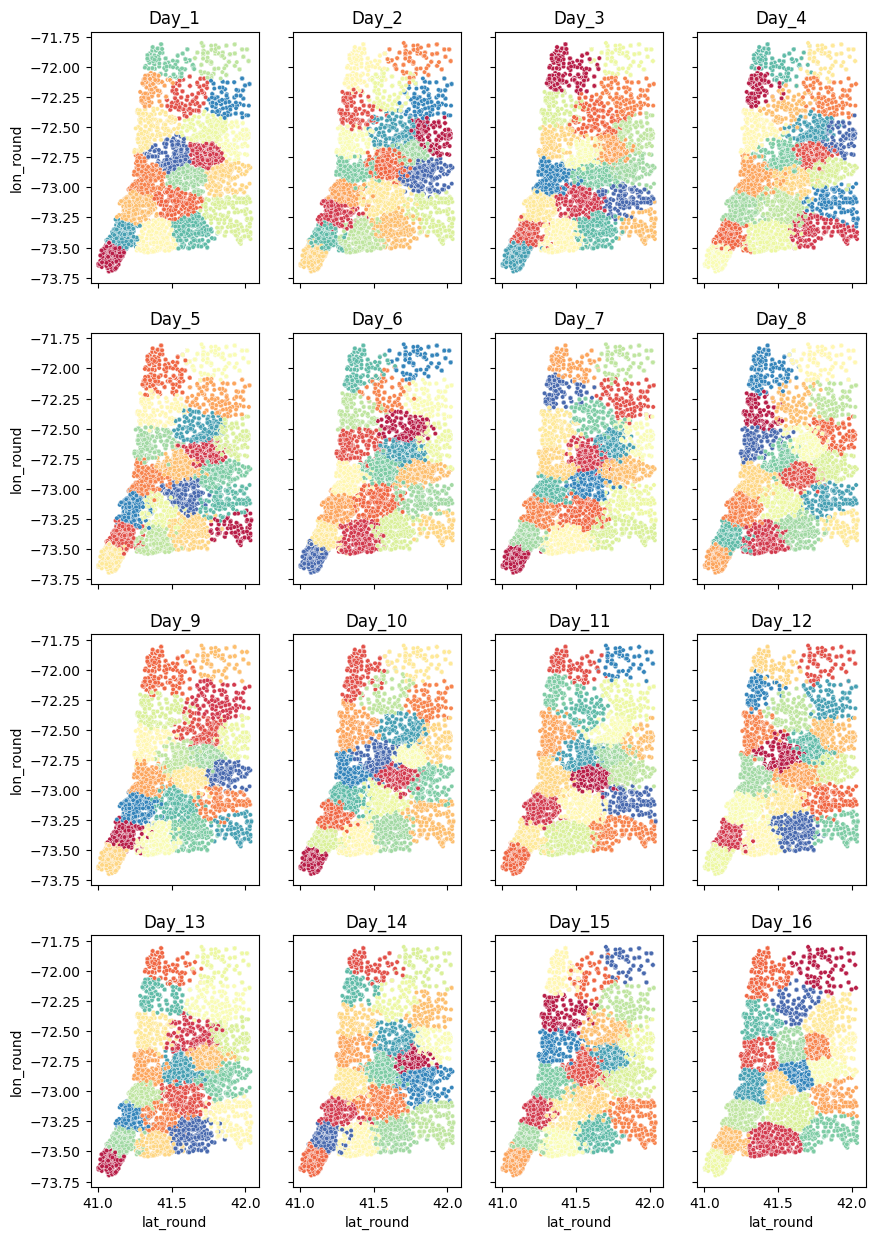

In [18]:
coloring = sns.color_palette("Spectral", n_colors=20)
icefire_coloring = sns.color_palette("icefire", n_colors=20)

fig, ax = plt.subplots(4, 4, figsize=(10,15), sharex=True, sharey=True)
for i in range(1, 17):
    hue_var = "col_" + str(i)
    sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = hue_var, 
                palette = coloring, s=10, legend=False, ax=ax[(i-1)//4][(i-1)%4])
    ax[(i-1)//4][(i-1)%4].set_title("Day_" + str(i))

### C.2 Calculate centroids, make new dataframe `df_centroids`.

In [19]:
def centroid(ls):
    arr = np.array(ls)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [(sum_x/length).round(2), (sum_y/length).round(2)]

def all_coor(df):
    return list(zip(df["lat_round"], df["lon_round"]))

In [20]:
df_temp = pd.DataFrame(df_new.groupby("col_1").apply(all_coor).reset_index(name = "ls_coord"))
df_temp["cent_1"] = df_temp["ls_coord"].apply(lambda r : centroid(r))
df_centroids = pd.DataFrame(df_temp[["col_1", "cent_1"]])

In [21]:
"""
Generate df_centroids.
"""
for i in range(2, 17):
    col_var = "col_" + str(i)
    cent_var = "cent_" + str(i)
    df_temp = pd.DataFrame(df_new.groupby(col_var).apply(all_coor).reset_index(name = "ls_coord"))
    df_temp[cent_var] = df_temp["ls_coord"].apply(lambda r : centroid(r))
    df_centroids[col_var] = df_temp[col_var]
    df_centroids[cent_var] = df_temp[cent_var]

In [22]:
df_centroids.head(3)

col_1           cent_1  col_2           cent_2  col_3           cent_3  \
0      1  [41.08, -73.57]      1  [41.89, -72.58]      1  [41.44, -72.05]   
1      2  [41.73, -72.72]      2  [41.23, -73.22]      2   [41.52, -73.1]   
2      3  [41.61, -72.24]      3  [41.36, -72.36]      3  [41.16, -73.38]   

   col_4           cent_4  col_5           cent_5  ...  col_12  \
0      1  [41.37, -72.16]      1  [41.93, -73.35]  ...       1   
1      2  [41.77, -73.37]      2   [41.73, -72.7]  ...       2   
2      3  [41.74, -72.72]      3  [41.16, -73.39]  ...       3   

           cent_12  col_13          cent_13  col_14          cent_14  col_15  \
0  [41.52, -72.72]       1  [41.08, -73.57]       1  [41.75, -72.73]       1   
1  [41.16, -73.38]       2  [41.65, -72.55]       2  [41.25, -73.17]       2   
2  [41.83, -71.93]       3  [41.59, -73.05]       3  [41.48, -71.96]       3   

           cent_15  col_16          cent_16  
0   [41.4, -72.36]       1  [41.81, -71.96]  
1  [41.23, -73.17]       2  [41.44, -73.42]  
2  [41.56, -72.81]       3  [41.37, -72.71]  

[3 rows x 32 columns]

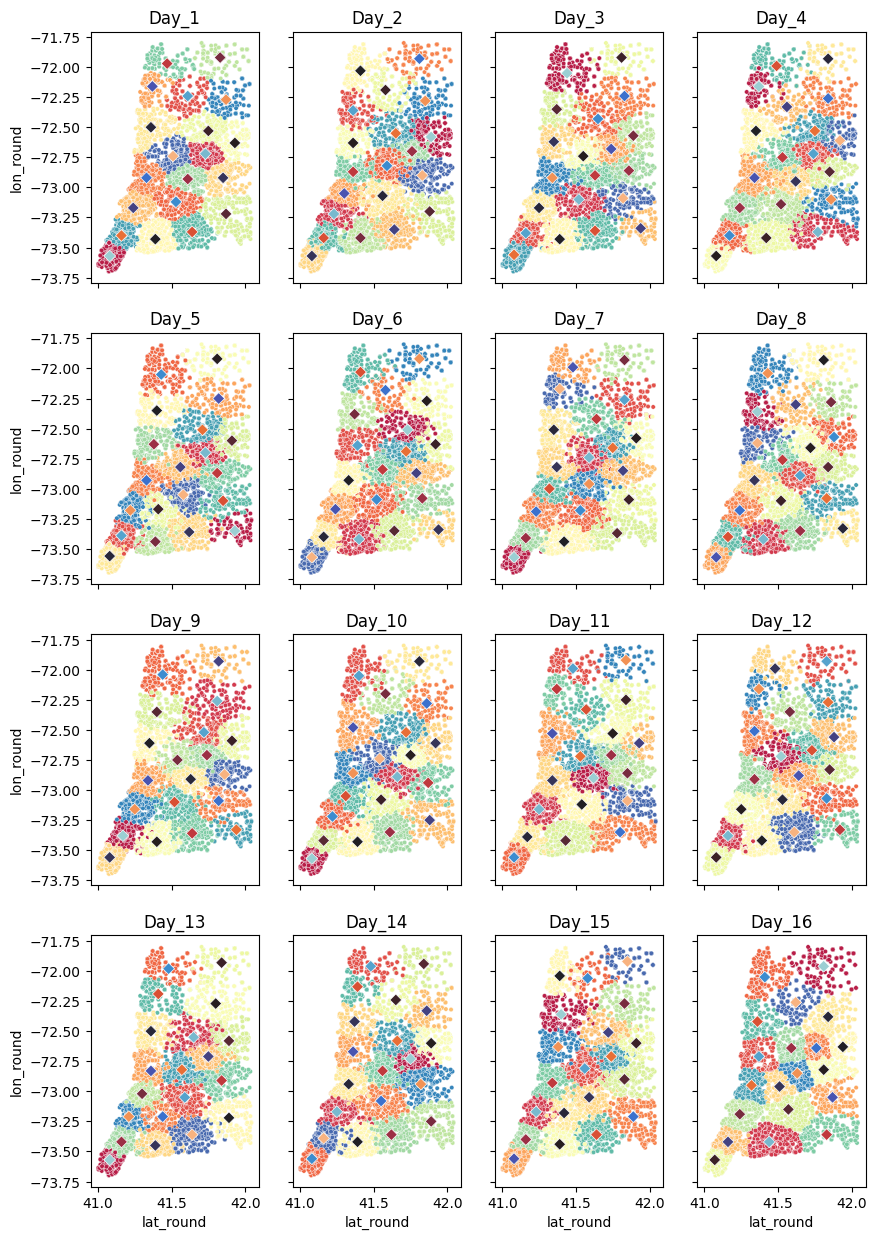

In [23]:
"""
Plot the clusters + centroids.
"""

fig, ax = plt.subplots(4, 4, figsize=(10,15), sharex=True, sharey=True)
for i in range(1, 17):
    hue_var = "col_" + str(i)
    cent_var = "cent_" + str(i)
    sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = hue_var, 
                palette = coloring, s=10, legend=False, ax=ax[(i-1)//4][(i-1)%4])
    sns.scatterplot(x = list(zip(*df_centroids[cent_var]))[0], 
                    y = list(zip(*df_centroids[cent_var]))[1], 
                    marker="D", legend=False, hue=hue_var, 
                    ax=ax[(i-1)//4][(i-1)%4], palette=icefire_coloring, data=df_centroids)
    ax[(i-1)//4][(i-1)%4].set_title("Day_" + str(i))

### C.3 Apply `pairwise_distance` function to re-order the memberships.
**Make copies of `df_new` and `df_centroids` to avoid changing the original dataframes.**

In [219]:
# del df_new2, df_cent2

In [201]:
df_cent2 = df_centroids.copy()
df_new2 = df_new.copy()

In [202]:
def unique_pairwise(df1, df2):
    """
    Input:
        df1, df2 - DataFrame[col, centroid]
    Output:
        new ids for df2's centroids.
    """
    ls1 = list(zip(df1.iloc[:,0], df1.iloc[:,1]))
    cent_2 = list(df2.iloc[:,1])
    order = []
    for pt in cent_2:
        idx = pairwise_distances_argmin([pt], list(zip(*ls1))[1])
        temp = ls1.pop(int(idx))
        order.append(temp[0])
    return order

**Work with `c1,c2` (2 subsets) first.**

In [203]:
c2, c1 = df_cent2[["col_2", "cent_2"]], df_cent2[["col_1", "cent_1"]]  # compare col2 to col1
# c2, c1 = df_cent2[["col_3", "cent_3"]], df_cent2[["col_2", "cent_2"]]

In [214]:
new = unique_pairwise(c1, c2)
c2.iloc[:,0] = new

/Users/xinranwan/anaconda3/envs/clustering_visual/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


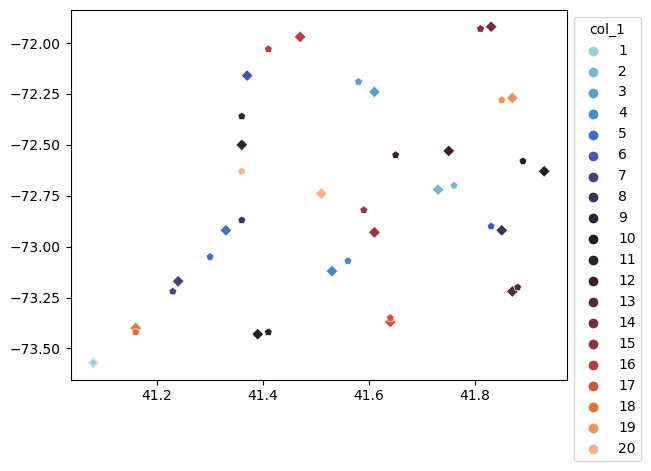

In [216]:
ax = sns.scatterplot(x = list(zip(*c1.iloc[:,1]))[0], 
                    y = list(zip(*c1.iloc[:,1]))[1], 
                    marker="D", hue=c1.columns[0], 
                    palette=icefire_coloring, data=c1)
sns.scatterplot(x = list(zip(*c2.iloc[:,1]))[0], 
                    y = list(zip(*c2.iloc[:,1]))[1], 
                    marker="p", hue=c2.columns[0], 
                    palette=icefire_coloring, data=c2, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [206]:
mapping = dict(zip(c2.iloc[:,0], new))
df_new2[c2.columns[0]] = df_new2[c2.columns[0]].apply(lambda x : mapping.get(x))
df_cent2[c2.columns[0]] = new

In [207]:
df_new2.head()

cluster_membership  lat_round  lon_round  col_1  col_2  col_3  col_4  \
0                  10     41.571    -73.018     15      4      2      8   
1                  19     41.814    -72.259     19     19      5      5   
2                  19     41.814    -72.259     19     19      5      5   
3                  19     41.814    -72.259     19     19      5      5   
4                  10     41.594    -73.051      4      4      2      8   

   col_5  col_6  col_7  col_8  col_9  col_10  col_11  col_12  col_13  col_14  \
0     20      4     19     12     17      12       1       9       3       5   
1      6     11      3     14      2       5      12      18      11       7   
2      6     11      3     14      2       5      12      18      11       7   
3      6     11      3     14      2       5      12      18      11       7   
4     20      4     19     12     17      12      10       9       3       5   

   col_15  col_16  
0       8       8  
1      14       9  
2      14       9  
3      14       9  
4       8      13

In [208]:
df_cent2.head()

col_1           cent_1  col_2           cent_2  col_3           cent_3  \
0      1  [41.08, -73.57]     11  [41.89, -72.58]      1  [41.44, -72.05]   
1      2  [41.73, -72.72]      7  [41.23, -73.22]      2   [41.52, -73.1]   
2      3  [41.61, -72.24]      9  [41.36, -72.36]      3  [41.16, -73.38]   
3      4  [41.53, -73.12]     15  [41.59, -72.82]      4  [41.65, -72.43]   
4      5  [41.33, -72.92]     14  [41.81, -71.93]      5  [41.83, -72.24]   

   col_4           cent_4  col_5           cent_5  ...  col_12  \
0      1  [41.37, -72.16]      1  [41.93, -73.35]  ...       1   
1      2  [41.77, -73.37]      2   [41.73, -72.7]  ...       2   
2      3  [41.74, -72.72]      3  [41.16, -73.39]  ...       3   
3      4   [41.17, -73.4]      4  [41.43, -72.05]  ...       4   
4      5  [41.84, -72.26]      5  [41.33, -72.93]  ...       5   

           cent_12  col_13          cent_13  col_14          cent_14  col_15  \
0  [41.52, -72.72]       1  [41.08, -73.57]       1  [41.75, -72.73]       1   
1  [41.16, -73.38]       2  [41.65, -72.55]       2  [41.25, -73.17]       2   
2  [41.83, -71.93]       3  [41.59, -73.05]       3  [41.48, -71.96]       3   
3  [41.83, -73.07]       4  [41.48, -71.98]       4  [41.08, -73.56]       4   
4  [41.34, -72.51]       5  [41.44, -73.21]       5  [41.55, -73.08]       5   

           cent_15  col_16          cent_16  
0   [41.4, -72.36]       1  [41.81, -71.96]  
1  [41.23, -73.17]       2  [41.44, -73.42]  
2  [41.56, -72.81]       3  [41.37, -72.71]  
3  [41.58, -72.06]       4  [41.41, -72.05]  
4  [41.89, -73.21]       5  [41.76, -72.64]  

[5 rows x 32 columns]

The specific grouping is in the **Notes**, there are issues with 2 groups.

Text(0.5, 1.0, 'Day_2')

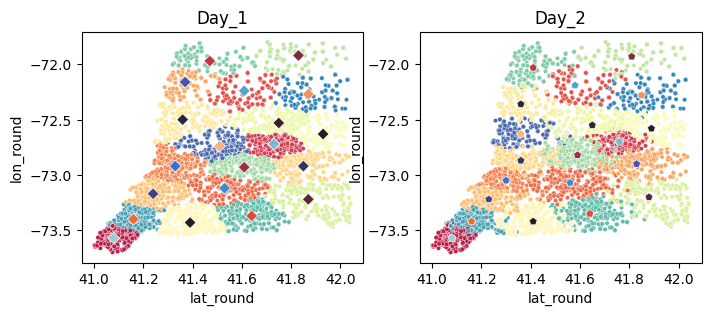

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new2, hue = c1.columns[0], 
                palette = coloring, s=10, legend=False, ax=ax[0])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new2, hue = c2.columns[0], 
                palette = coloring, s=10, legend=False, ax=ax[1])
sns.scatterplot(x = list(zip(*c1.iloc[:,1]))[0], 
                    y = list(zip(*c1.iloc[:,1]))[1], 
                    marker="D", hue=c1.columns[0], 
                    palette=icefire_coloring, data=c1, legend=False, ax=ax[0])
sns.scatterplot(x = list(zip(*c2.iloc[:,1]))[0], 
                    y = list(zip(*c2.iloc[:,1]))[1], 
                    marker="p", hue=c2.columns[0], 
                    palette=icefire_coloring, data=c2, legend=False, ax=ax[1])
ax[0].set_title("Day_1")
ax[1].set_title("Day_2")

**Generalize to the rest columns**   
Compare centroids with the previous day, not the 1st day.

In [210]:
for i in range(3, 17):
    col_var = "col_" + str(i)
    cent_var = "cent_" + str(i)
    prev, now = df_cent2[["col_" + str(i-1), "cent_" + str(i-1)]], df_cent2[[col_var, cent_var]]
    new = unique_pairwise(prev, now)
    mapping = dict(zip(now[col_var], new))
    df_new2[col_var] = df_new2[col_var].apply(lambda x : mapping.get(x))
    df_cent2[now.columns[0]] = new

In [211]:
df_new2

cluster_membership  lat_round  lon_round  col_1  col_2  col_3  col_4  \
0                      10     41.571    -73.018     15      4      4      8   
1                      19     41.814    -72.259     19     19     19     19   
2                      19     41.814    -72.259     19     19     19     19   
3                      19     41.814    -72.259     19     19     19     19   
4                      10     41.594    -73.051      4      4      4      8   
...                   ...        ...        ...    ...    ...    ...    ...   
12823                  14     42.008    -72.520     11     11     11     13   
12824                   2     41.708    -72.860     15      6      8      8   
12825                   2     41.708    -72.860     15     15      8      6   
12826                   2     41.708    -72.860     15      6      8      8   
12827                   2     41.708    -72.860     15     15      8      6   

       col_5  col_6  col_7  col_8  col_9  col_10  col_11  col_12  col_13  \
0         16     16     17     16     16      16      17      16      16   
1         19     19     19     19     19      19      19      19      19   
2         19     19     19     19     19      19      19      19      19   
3         19     19     19     19     19      19      19      19      19   
4         16     16     17     16     16      16      16      16      16   
...      ...    ...    ...    ...    ...     ...     ...     ...     ...   
12823     13     13     13     13     13      13      13      13      13   
12824      6     15      6     17     17      17      17      17      20   
12825     15      6      6     17     17      17      17      17       3   
12826     15     15      6     17     17      17      17      17      20   
12827      6      6      6     17     17      17      17      17      20   

       col_14  col_15  col_16  
0          16      16      16  
1          19      19      19  
2          19      19      19  
3          19      19      19  
4          16      16       7  
...       ...     ...     ...  
12823      13      13      13  
12824       8       8      11  
12825       8       8      11  
12826       8      20      11  
12827       8       8      11  

[12828 rows x 19 columns]

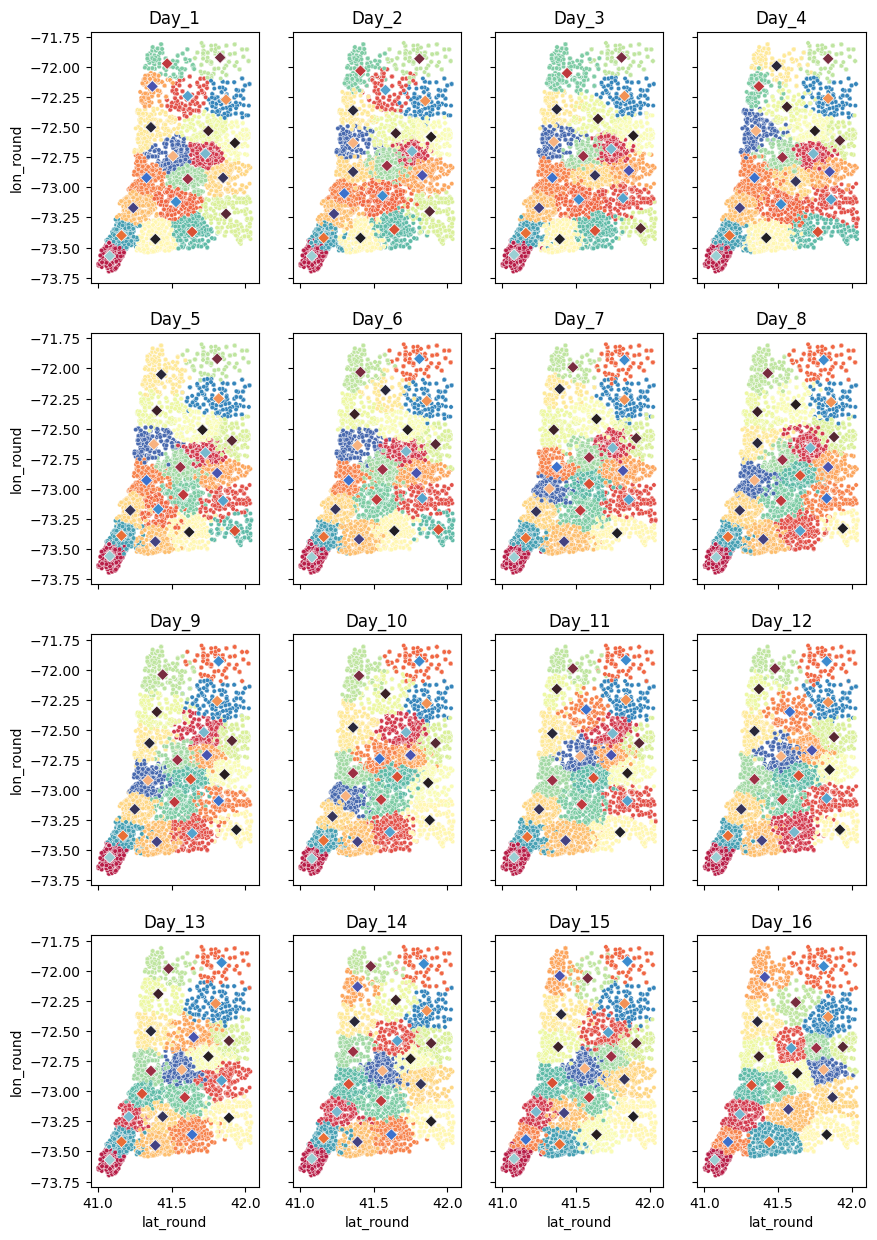

In [218]:
fig, ax = plt.subplots(4, 4, figsize=(10,15), sharex=True, sharey=True)
for i in range(1, 17):
    hue_var = "col_" + str(i)
    cent_var = "cent_" + str(i)
    sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new2, hue = hue_var, 
                palette = coloring, s=10, legend=False, ax=ax[(i-1)//4][(i-1)%4])
    sns.scatterplot(x = list(zip(*df_cent2[cent_var]))[0], 
                    y = list(zip(*df_cent2[cent_var]))[1], 
                    marker="D", legend=False, hue=hue_var, 
                    ax=ax[(i-1)//4][(i-1)%4], palette=icefire_coloring, data=df_cent2)
    ax[(i-1)//4][(i-1)%4].set_title("Day_" + str(i))

## D. Animation for the changes

Check this: https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

In [ ]:
import matplotlib.animation as ani

animator = ani.FuncAnimation(fig, chartfunc, interval = 100)

In [ ]:
color = ['red', 'green', 'blue', 'orange']
fig = plt.figure()
plt.xticks(rotation=45, ha="right", rotation_mode="anchor") #rotate the x-axis values
plt.subplots_adjust(bottom = 0.2, top = 0.9) #ensuring the dates (on the x-axis) fit in the screen
plt.ylabel('No of Deaths')
plt.xlabel('Dates')

In [ ]:
def buildmebarchart(i=int):
    plt.legend(df1.columns)
    p = plt.plot(df1[:i].index, df1[:i].values) #note it only returns the dataset, up to the point i
    for i in range(0,4):
        p[i].set_color(color[i]) #set the colour of each curve
import matplotlib.animation as ani
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 100)
plt.show()